In [1]:
from PISNml import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
sample = 'Silver/'
PISN_split = '-1_'
curve = 'Complete/'
model = 'poly'
purpose = 'test'

In [3]:
data = pd.read_pickle("../../plasticc/param_table/"+sample+curve+purpose+PISN_split+model+".pkl")

In [4]:
data

,object_id,target,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,13,42,8.315272e-07,-0.000220,0.003228,0.941658,52.0,24.529644,1.165023e-06,-0.000438,...,0.006599,0.674313,51.0,42.765503,1.072700e-06,-0.000159,-0.043651,1.206321,51.0,36.802090
1,14,42,1.043327e-06,-0.001082,0.218847,0.744413,52.0,14.465278,1.713310e-06,-0.002047,...,0.602944,2.009885,51.0,9.230726,-1.526946e-07,-0.000130,0.206442,3.259098,51.0,14.839427
2,17,42,4.641806e-07,-0.000197,0.031918,0.974416,58.0,12.973317,3.850994e-07,0.000072,...,-0.038193,2.107325,58.0,12.109291,-7.538624e-09,0.000478,-0.124074,4.022734,57.0,16.761280
3,23,90,-1.426843e-06,0.001406,-0.089316,2.543105,52.0,5.387752,-2.227311e-06,0.001885,...,-0.101487,0.877022,51.0,21.272690,-1.984103e-06,0.001726,-0.117388,1.459547,51.0,28.061138
4,34,90,-1.172269e-06,0.001073,-0.069684,1.124961,58.0,124.475609,-1.110185e-06,0.001021,...,-0.044323,1.036356,58.0,111.523895,-1.041445e-06,0.000971,-0.090383,1.267607,57.0,90.760689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32694,342818,67,-1.374100e-06,0.001175,-0.057490,0.710243,56.0,72.033432,-1.861249e-06,0.001600,...,-0.090719,0.912872,56.0,141.229965,-1.948159e-06,0.001664,-0.082198,0.921868,55.0,121.277580
32695,342825,42,4.998490e-07,0.000145,-0.047420,2.457405,56.0,4.396688,1.184399e-06,-0.000248,...,0.078292,1.200628,56.0,13.672332,1.682807e-06,-0.000857,0.050437,1.620999,56.0,21.398048
32696,342834,90,9.304841e-07,-0.001215,0.359726,1.074035,56.0,35.456642,9.692496e-07,-0.001261,...,0.445440,1.241038,56.0,44.910275,1.040203e-06,-0.001412,0.461396,1.638422,56.0,49.754597
32697,342860,42,1.064644e-06,-0.000517,0.051827,1.109443,45.0,22.257574,1.126362e-06,-0.000439,...,0.092622,0.975970,45.0,17.354675,-4.200380e-08,0.000130,0.014748,0.553154,45.0,97.282578


In [5]:
table_iso, table_score = create_if(data,[2,3,4,5],6,100)

In [8]:
top_score = table_score.sort_values(by = 'score', ignore_index=True)
top_score[top_score['target']==62]

,score,target,object_id
47,-0.252515,62.0,198625.0
69,-0.248546,62.0,144531.0
194,-0.214772,62.0,91292.0
217,-0.207521,62.0,12416.0
231,-0.202881,62.0,17471.0
...,...,...,...
130725,0.143200,62.0,45065.0
130762,0.143566,62.0,228915.0
130765,0.143621,62.0,148567.0
130785,0.144168,62.0,213442.0


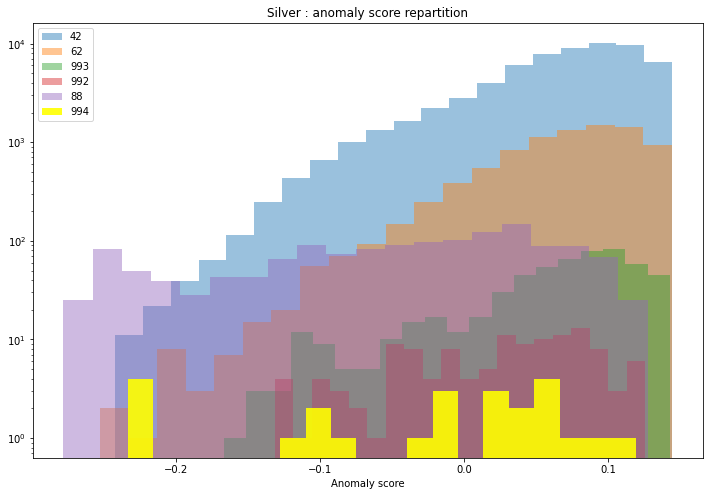

In [10]:
plt.figure(figsize = (12,8))
plt.yscale("log")


targetofinterest = [42,62,993,992,88]


plt.title('Silver : anomaly score repartition')
for i in targetofinterest:
    target = i
    plt.hist(top_score.loc[top_score['target']==target,'score'],bins=20,label = i,alpha = 0.45);

plt.hist(top_score.loc[top_score['target']==994,'score'],bins=20,label = 994,alpha = 0.9,color = 'yellow');
plt.xlabel('Anomaly score')
plt.legend()
#plt.savefig("Silver_hist_anomaly.png")